In [13]:
!pip install pandas numpy matplotlib seaborn scikit-learn prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
df = pd.read_csv("/content/drive/MyDrive/demand-forecasting-kernels-only/train.csv")

# Dataset: 145k+ records (date, store, item, sales)
print(df.shape)
df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [15]:
df['date'] = pd.to_datetime(df['date'])
weekly_sales = df.groupby(pd.Grouper(key='date', freq='W'))['sales'].sum().reset_index()

print(weekly_sales.head())

        date   sales
0 2013-01-06   91067
1 2013-01-13  103902
2 2013-01-20  102950
3 2013-01-27  103298
4 2013-02-03  109027


DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6lhn2t/u5kfb4q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvf6lhn2t/gms7wogs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78839', 'data', 'file=/tmp/tmpvf6lhn2t/u5kfb4q2.json', 'init=/tmp/tmpvf6lhn2t/gms7wogs.json', 'output', 'file=/tmp/tmpvf6lhn2t/prophet_model_pt6_it4/prophet_model-20250915082602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


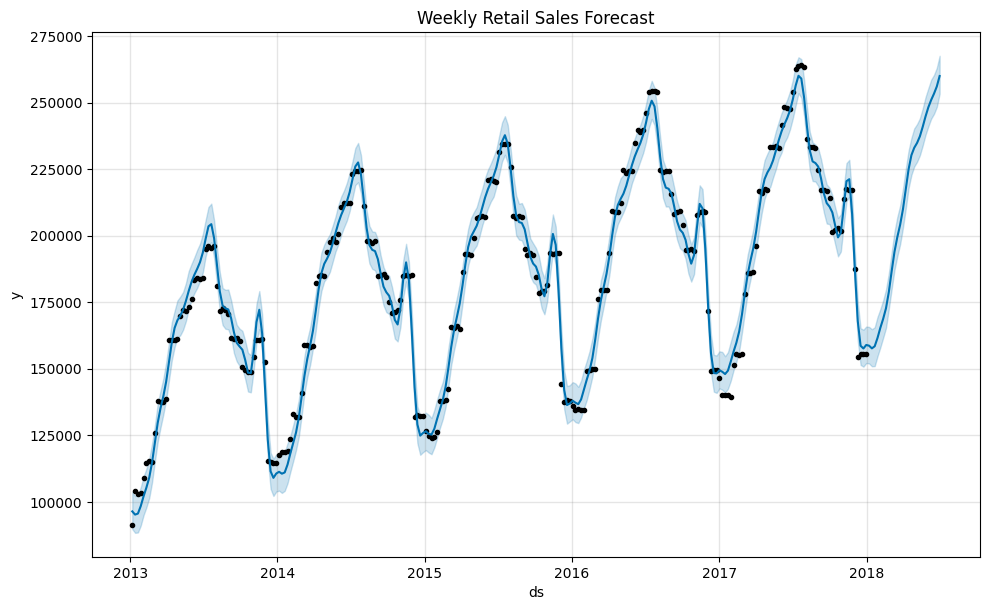

In [16]:
prophet_df = weekly_sales.rename(columns={'date': 'ds', 'sales': 'y'})

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_df)

# Forecast next 26 weeks (~6 months)
future = model.make_future_dataframe(periods=26, freq='W')
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Weekly Retail Sales Forecast")
plt.show()

In [18]:
y_true = prophet_df['y'].values
y_pred = forecast['yhat'][:len(y_true)].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", round(mape,2), "%")

MAE: 4440.401937930428
RMSE: 5546.542999759548
MAPE: 2.62 %


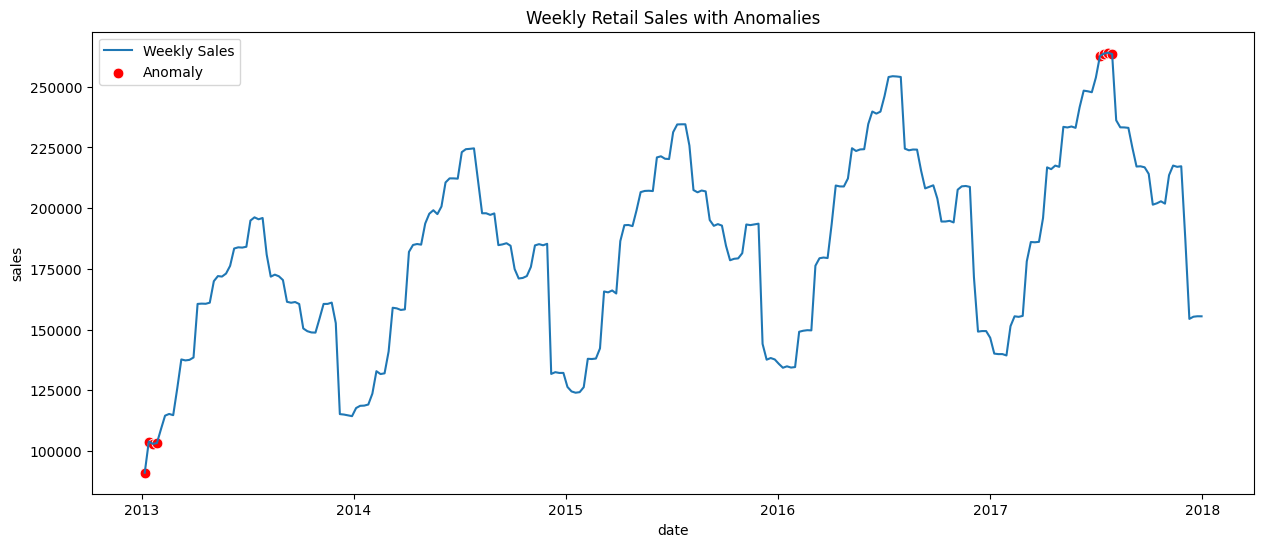

In [19]:
# Python: Z-score method
weekly_sales['zscore'] = (weekly_sales['sales'] - weekly_sales['sales'].mean()) / weekly_sales['sales'].std()
weekly_sales['anomaly'] = weekly_sales['zscore'].apply(lambda x: 'Anomaly' if abs(x) > 2 else 'Normal')

# Plot anomalies
plt.figure(figsize=(15,6))
sns.lineplot(data=weekly_sales, x='date', y='sales', label="Weekly Sales")
sns.scatterplot(data=weekly_sales[weekly_sales['anomaly']=='Anomaly'],
                x='date', y='sales', color='red', s=60, label="Anomaly")
plt.title("Weekly Retail Sales with Anomalies")
plt.show()

In [20]:
sql_query = """
SELECT date, sales,
CASE WHEN sales > AVG(sales) + 2*STDDEV(sales)
      OR sales < AVG(sales) - 2*STDDEV(sales)
     THEN 'Anomaly' ELSE 'Normal' END as anomaly_flag
FROM sales_table
GROUP BY date, sales;
"""
print(sql_query)



SELECT date, sales,
CASE WHEN sales > AVG(sales) + 2*STDDEV(sales)
      OR sales < AVG(sales) - 2*STDDEV(sales)
     THEN 'Anomaly' ELSE 'Normal' END as anomaly_flag
FROM sales_table
GROUP BY date, sales;



In [22]:
output = forecast[['ds','yhat','yhat_lower','yhat_upper']]
output = output.merge(weekly_sales[['date','sales','anomaly']], left_on='ds', right_on='date', how='left')
output.drop(columns=['date'], inplace=True)

# Save for dashboards
output.to_csv("/content/drive/MyDrive/retail_forecast_with_anomalies.csv", index=False)